In [3]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
adata = sc.read_h5ad('../GBM_Linnarsson_EEL.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [17]:
rename_dic = {
    'GW-like 5':'GW-like Endo.Ass.',
    'GW-like 2':'GW-like Periphery1',
    'GW-like 3':'GW-like Periphery2',
    'GW-like 1':'GW-like Periphery3',
    
    'GW-like 6':'GW-like HYPR1',
    'GW-like 8':'GW-like HYPR2',
    'GW-like 7':'GW-like OPC',
    'GW-like 4':'GW-like nIPC',
    
    'nIPC-RG-like':'RG-like',
    
 
}

adata.obs['m-states3'] = pd.Categorical([rename_dic[m] if m in rename_dic else m for m in adata.obs['m-states2']])

In [30]:
adata.obs['m-states3'] = ['Endothelial' if ms.count('Endothelial') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = ['Oligodendrocyte' if ms.count('Oligodendrocyte') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = pd.Categorical(['Mural cell' if ms.count('Mural') else ms for ms in adata.obs['m-states3']])

In [31]:
adata.obs['m-states3'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'Astrocyte', 'DC', 'Endothelial',
       'Erythrocyte 1', 'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1',
       'GBL-like 2', 'GW-like Endo.Ass.', 'GW-like HYPR1', 'GW-like HYPR2',
       'GW-like OPC', 'GW-like Periphery1', 'GW-like Periphery2',
       'GW-like Periphery3', 'GW-like nIPC', 'Mono 1', 'Mono 2', 'Mural cell',
       'OPC-like 1', 'OPC-like 2', 'Oligodendrocyte', 'RG-like', 'TAM-BDM 1',
       'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'nIPC-like 1',
       'nIPC-like 2', 'nIPC-like 3', 'preOPC-like 1', 'unknown 1',
       'unknown2 1'],
      dtype='object')

In [38]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'GW-like Endo.Ass.':'#e76d89',# Deep cerise
    'GW-like Periphery1':'#e76d89',# Deep cerise
    'GW-like Periphery2':'#e76d89',# Deep cerise
    'GW-like Periphery3':'#e76d89',# Deep cerise
    'GW-like HYPR1':'#e76d89',# Deep cerise
    'GW-like HYPR2':'#e76d89',# Deep cerise
    'GW-like nIPC':'#e76d89',# Deep cerise
    'GW-like OPC':'#e76d89',# Deep cerise
    
    #'nIPC-like 1':'#FFF192',
    #'nIPC-like 2':'#FFF192',
    #'nIPC-like 3':'#FFF192',
    
    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    
    'TAM-BDM 1':'#e3ba8f', #wood
    'TAM-BDM 2':'#e3ba8f',
    'TAM-BDM 3':'#e3ba8f',
    'TAM-BDM 4':'#e3ba8f', #wood

    'TAM-MG':'#a6915c',#red orange
    'Mono 1': '#f4ede4',
    'Mono 2': '#f4ede4',
    
    'Oligodendrocyte':'#392e4a',
    'Astrocyte':'#038aff',
    
    #'Endothelial':'#d5b8ff', #mauve
    #'Mural cell': '#8c14fc',  #electric indigo
    #'Mural': '#8c14fc',  #electric indigo
    
    'Endothelial':'#C8E683', # '#d5b8ff',  

    #'FB-like 1': '#9f5afd', #fff9de
    'FB-like 2': '#9f5afd', #fff9de
    'FB-like 3': '#9f5afd', #fff9de

}

# All Samples

SL001A


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.23/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

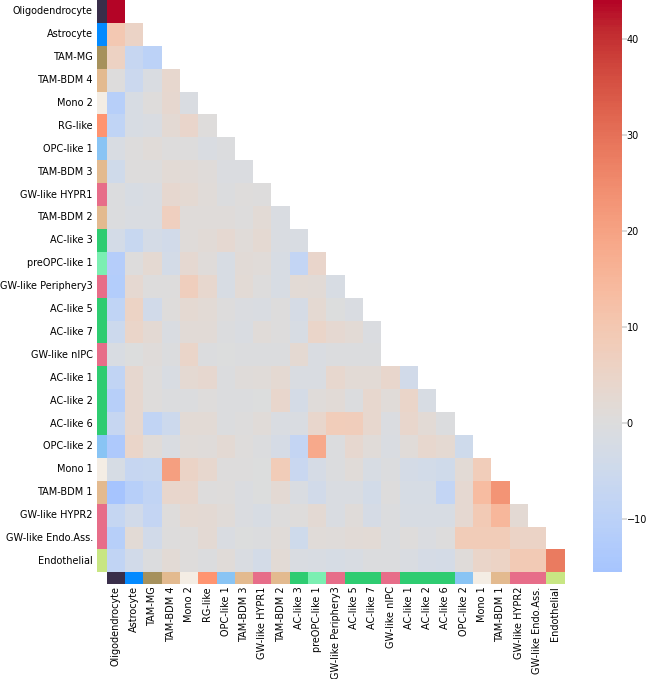

SL001B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.60/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

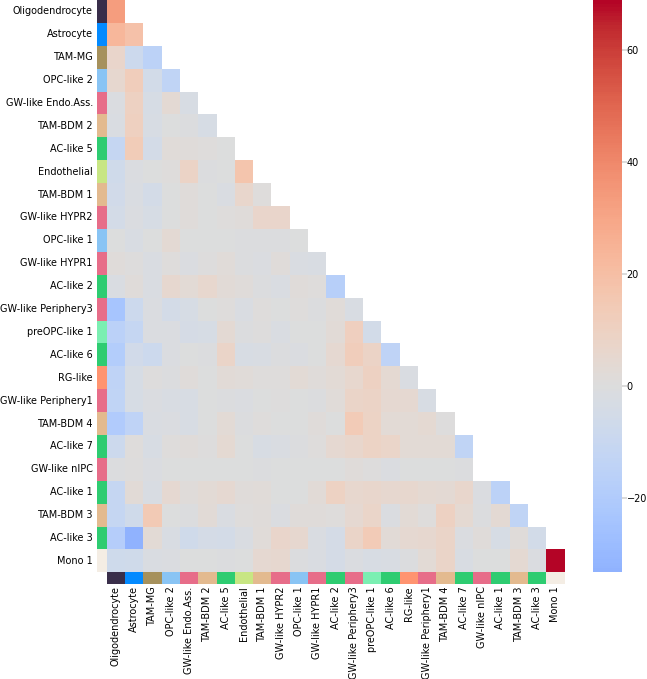

SL002


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.85/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

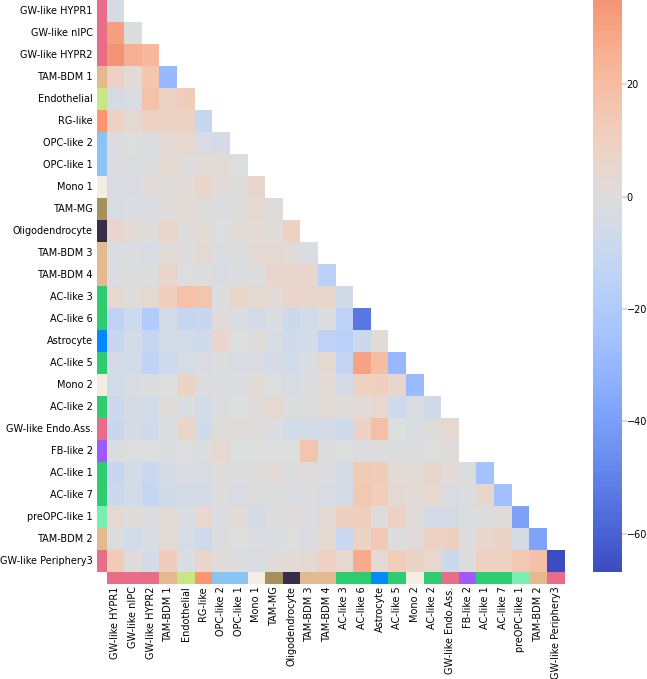

SL003


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.16/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 43, 4

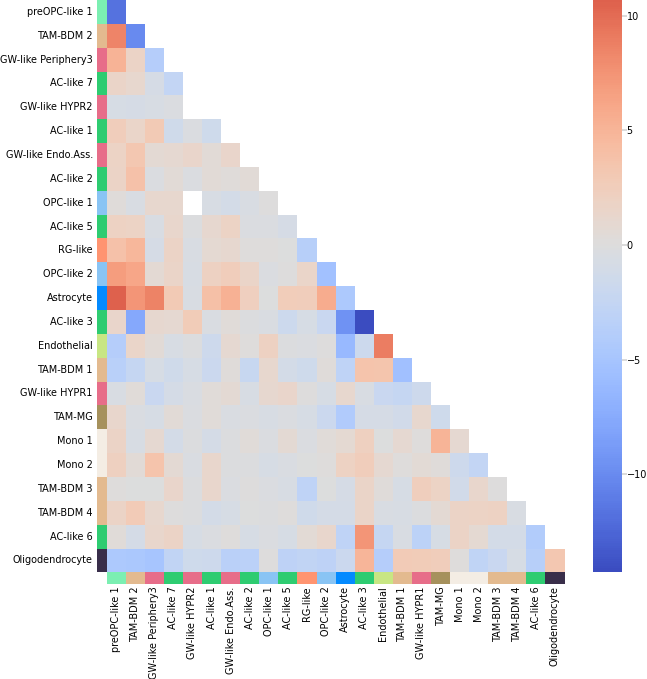

SL005


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1814.67/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

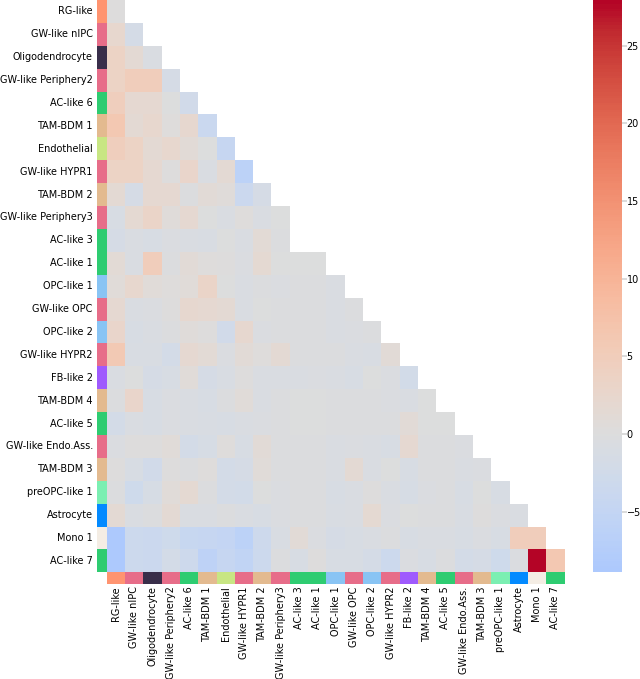

SL006


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.86/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

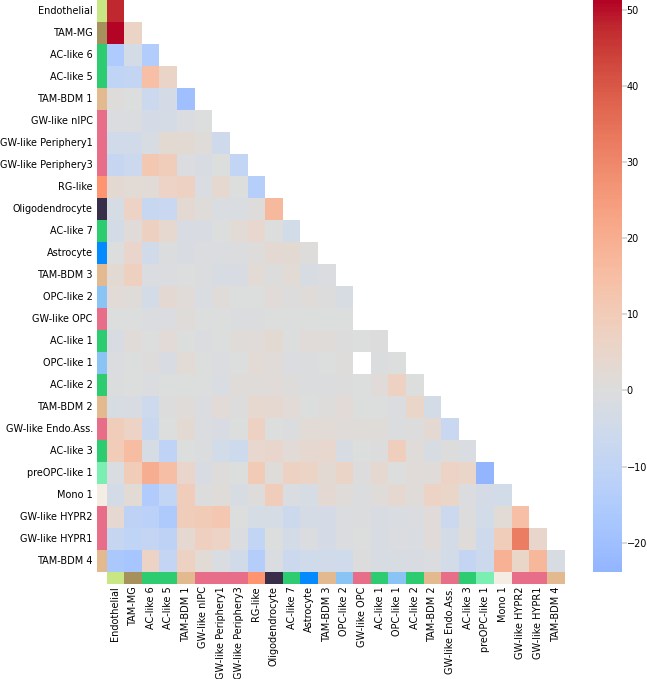

SL011


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1661.61/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

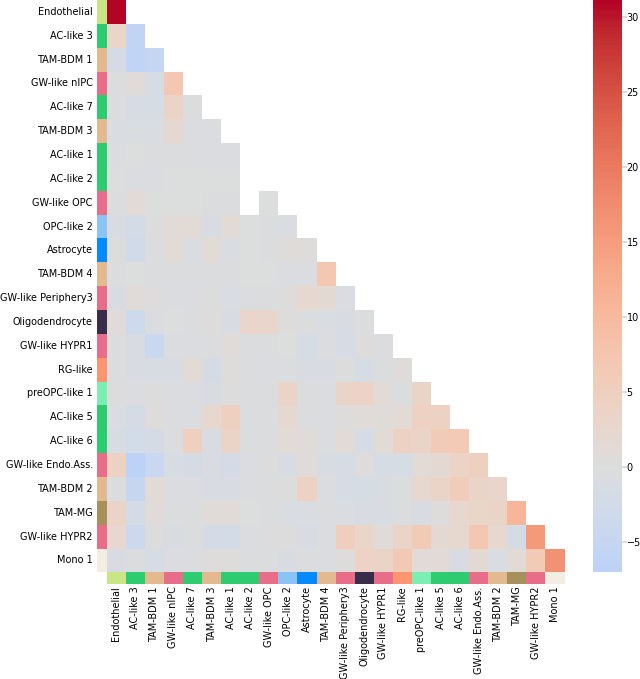

SL012


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.78/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

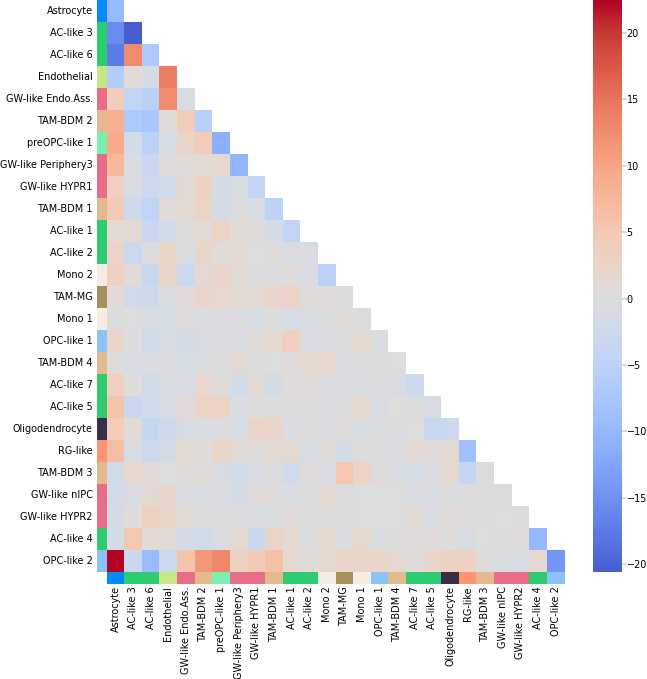

SL013


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 755.24/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

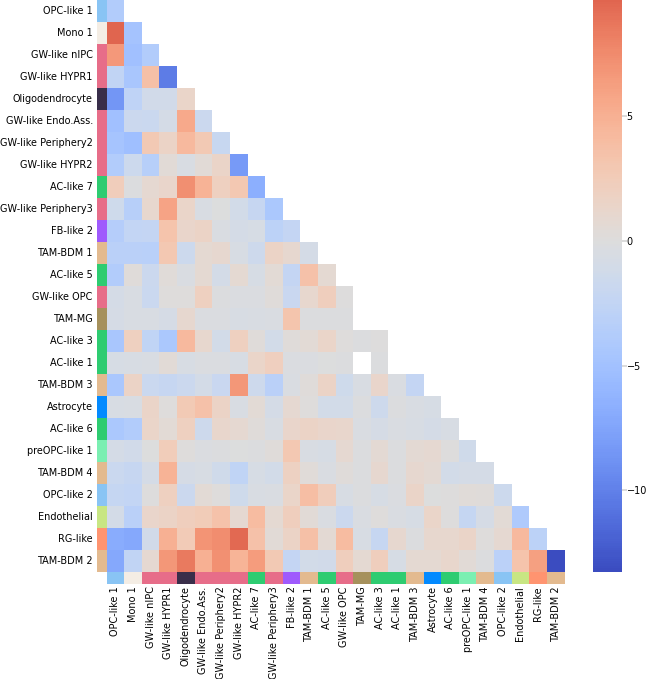

SL015


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.83/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

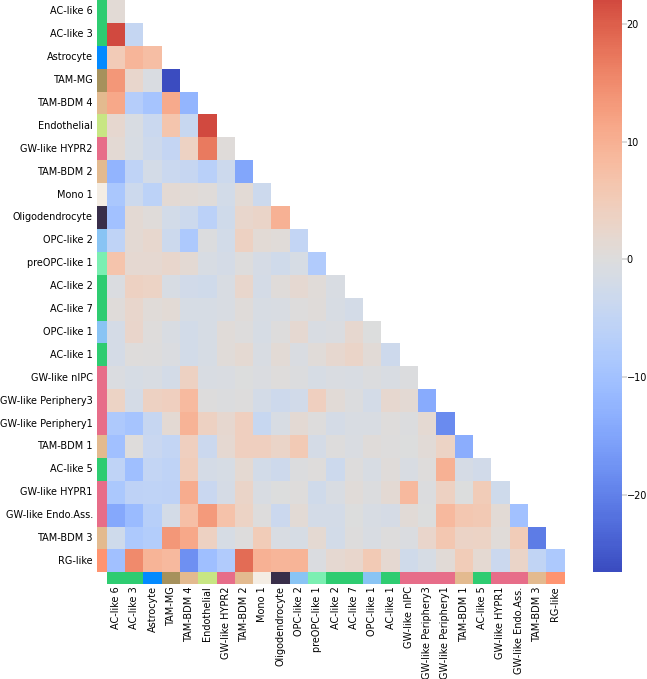

SL016A


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.81/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

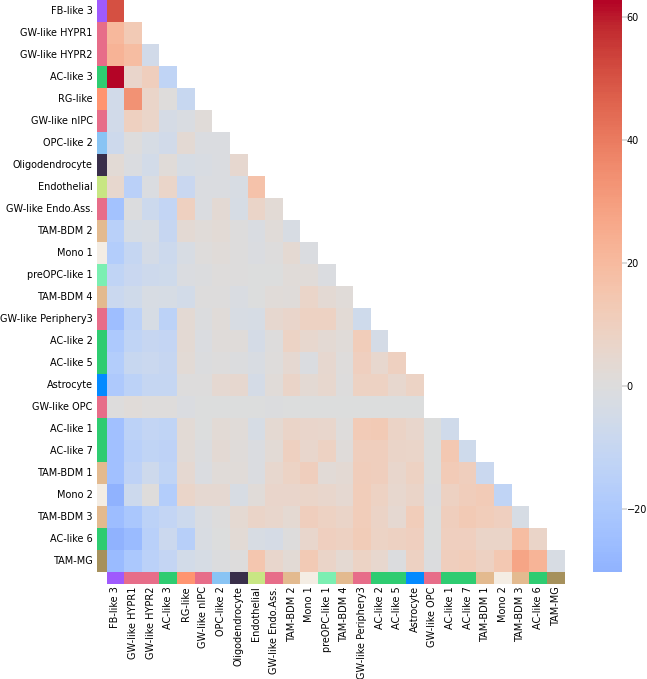

SL016B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 690.27/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

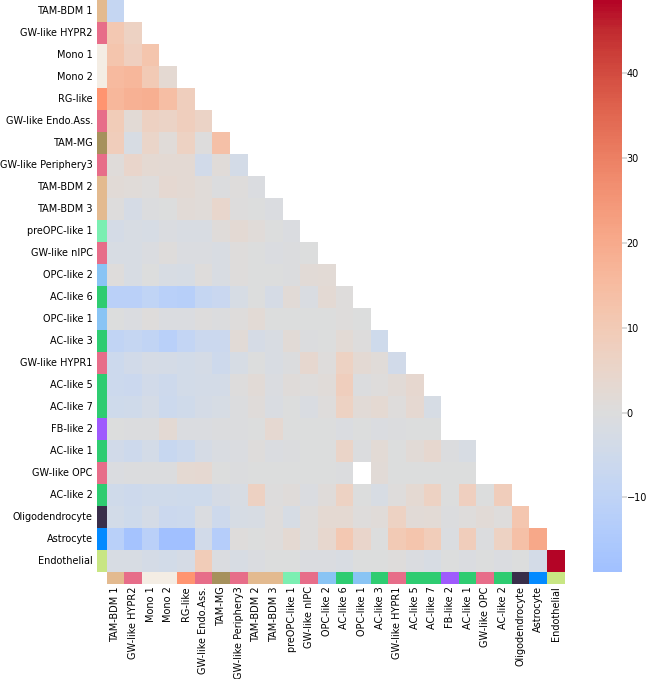

SL018


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.72/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

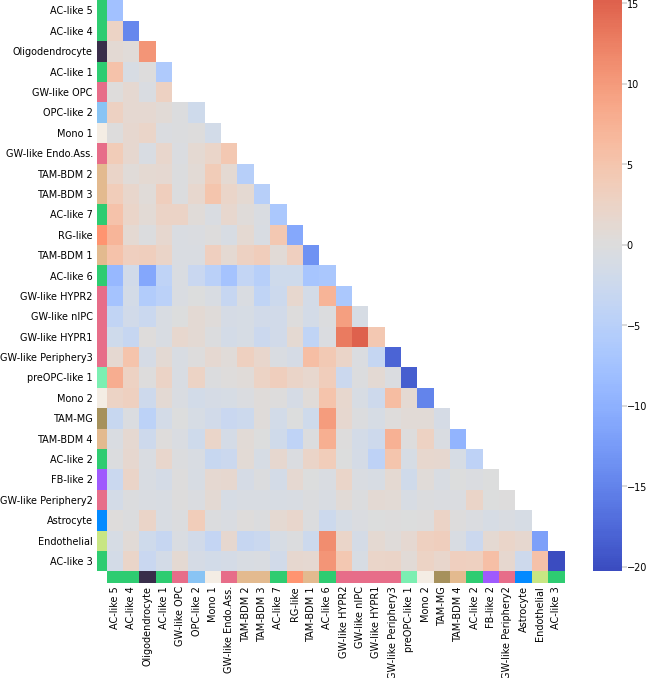

SL019


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.60/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

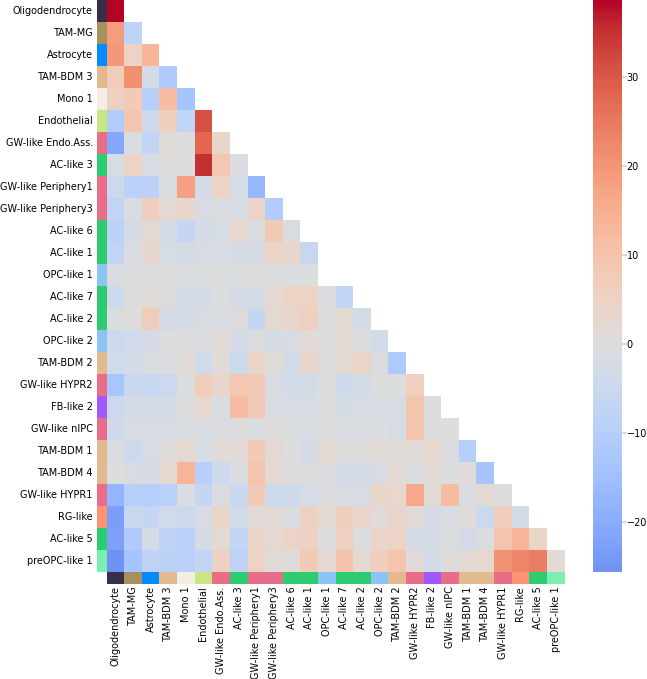

SL020


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.52/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37

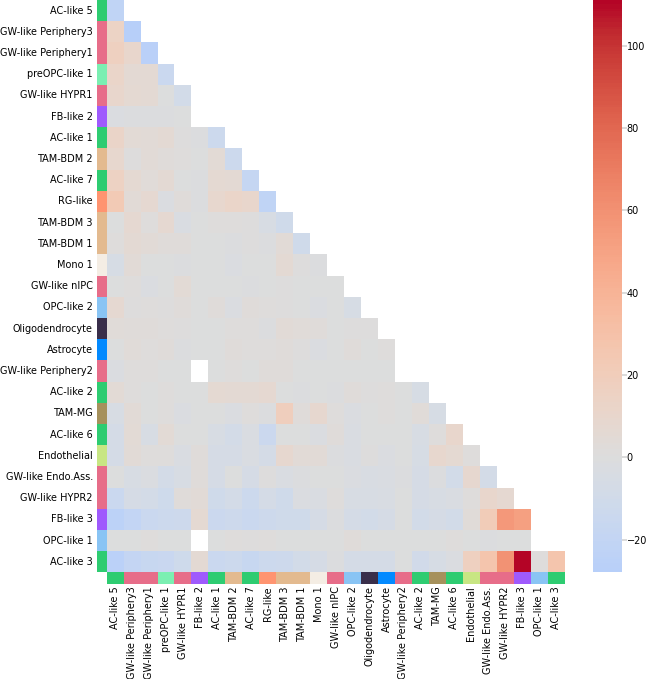

SL023


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.71/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

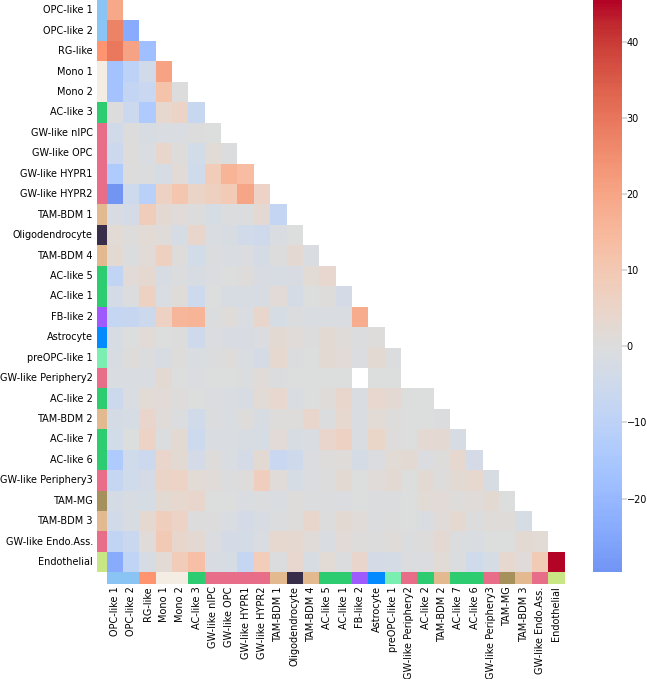

SL027B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.54/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

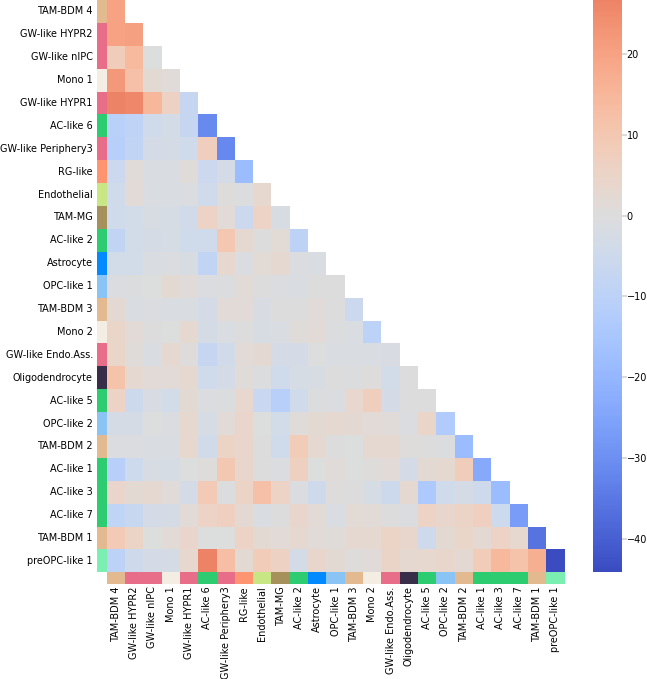

SL029


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.74/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

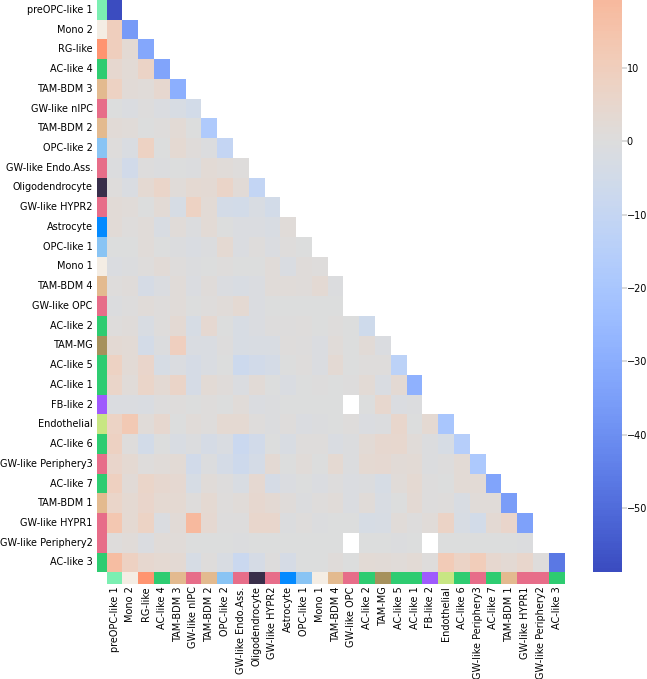

SL030


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.32/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 24, 25, 26, 36, 37, 38, 39, 40, 42, 43, 44, 48, 

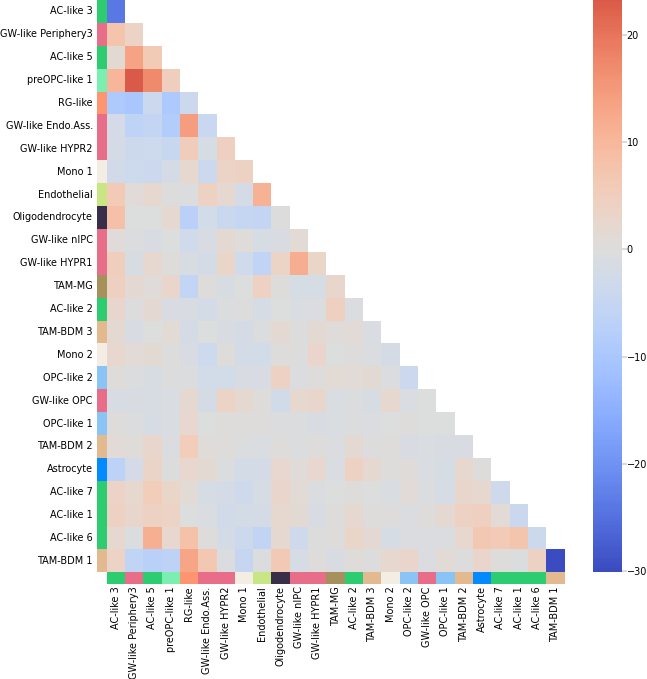

SL034


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.90/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

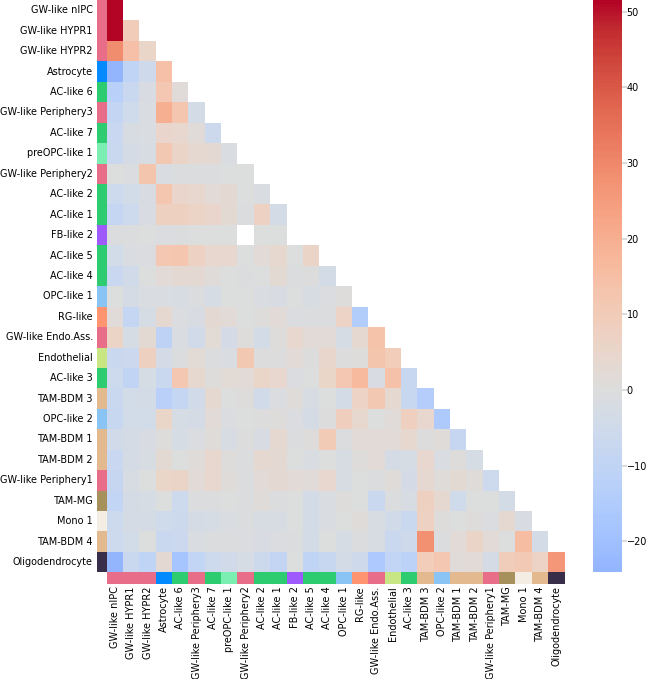

SL035A


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.10/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

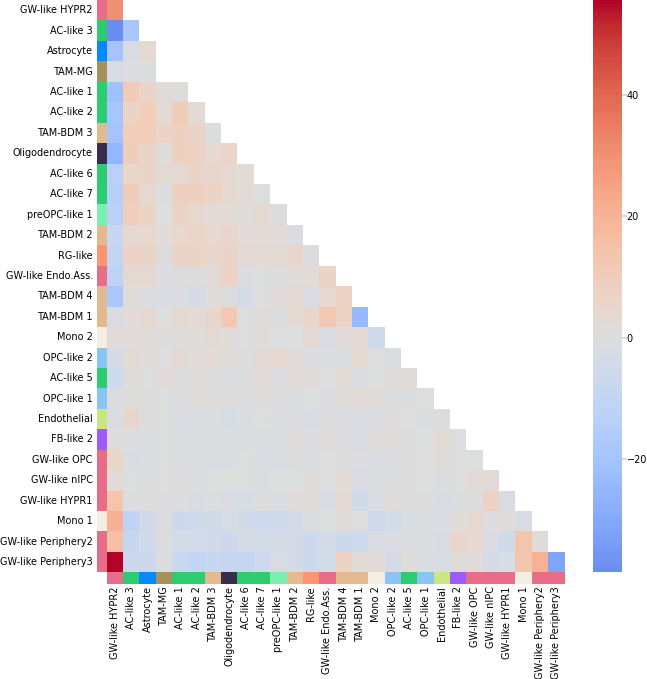

SL035B


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.80/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

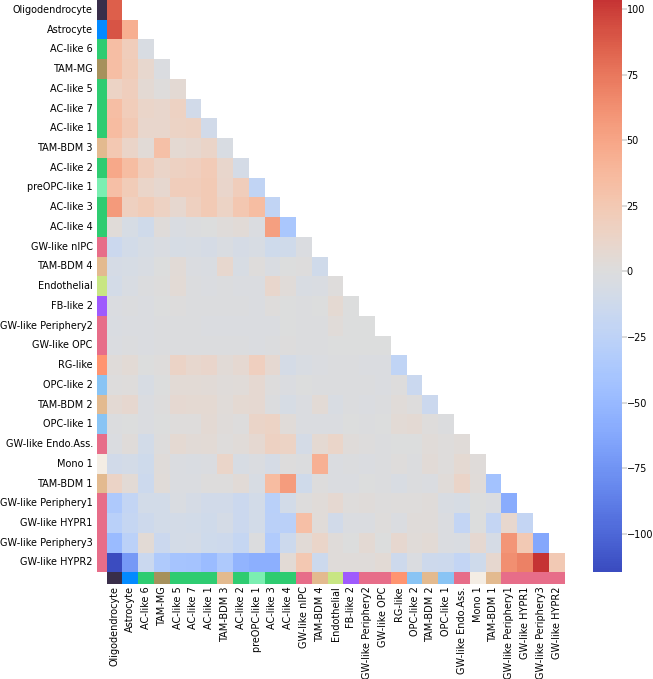

SL037


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.12/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

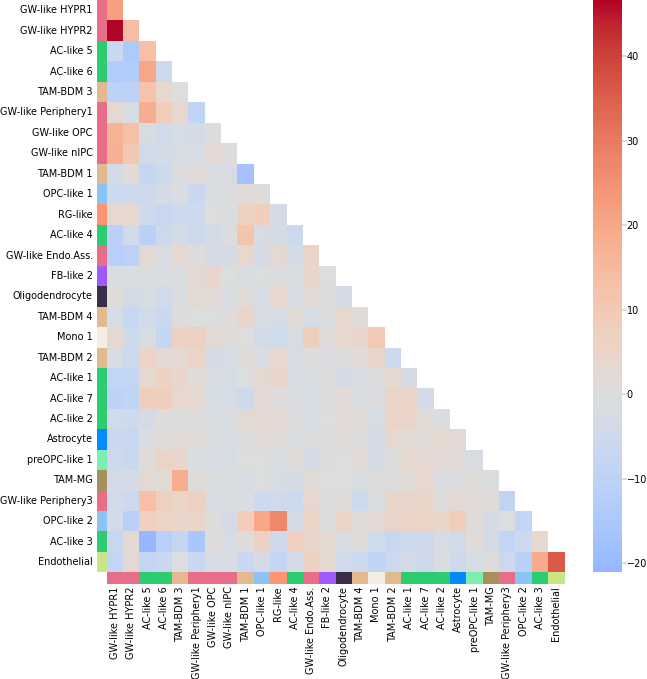

SL038


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.82/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

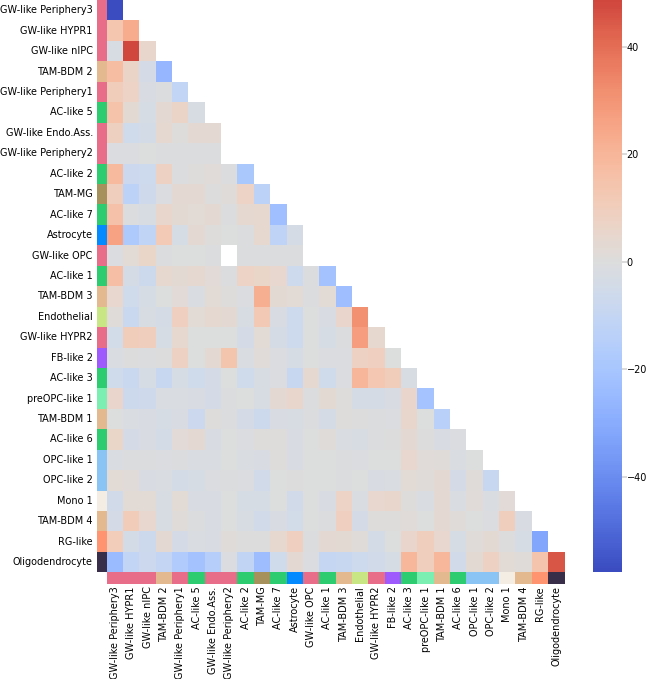

SL040B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.27/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

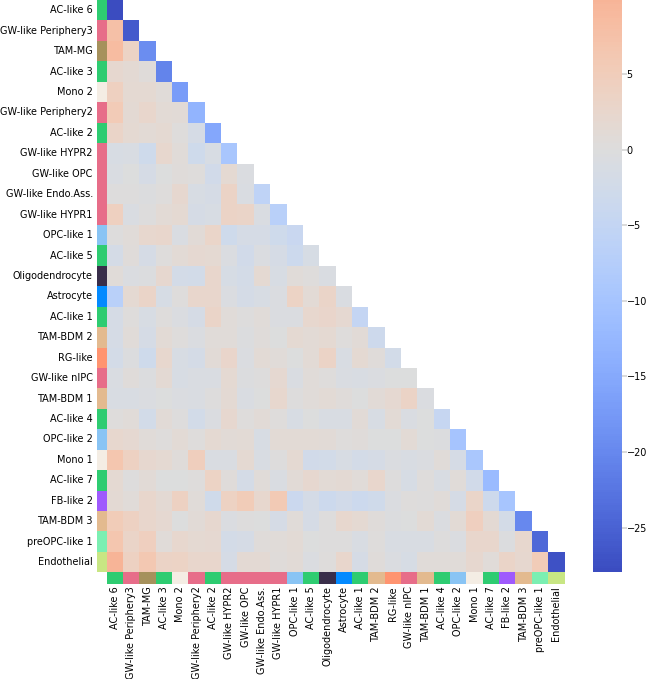

SL040Bulk


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.80/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

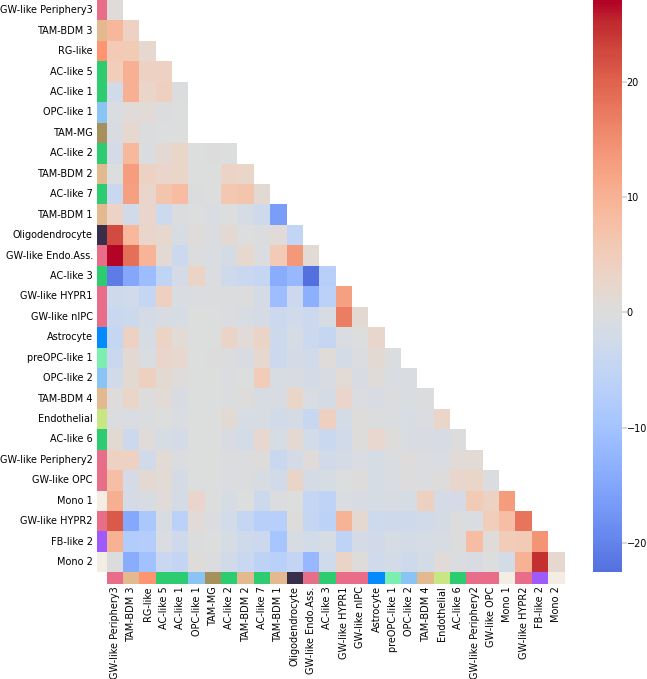

SL040C


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1041.20/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

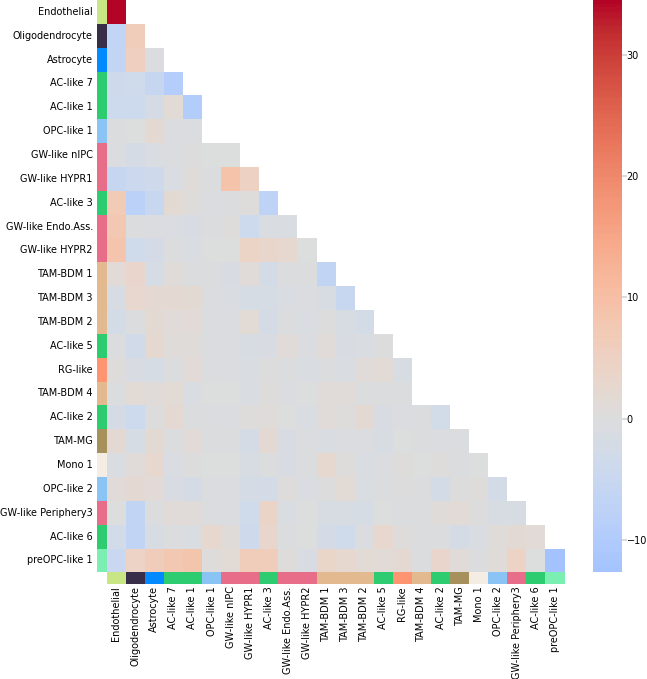

SL040D


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 697.45/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 43, 4

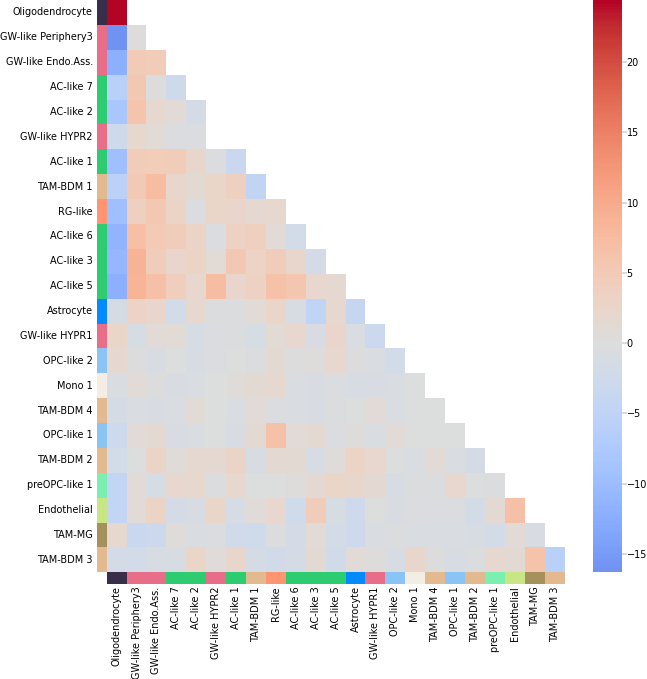

SL040E


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.32/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

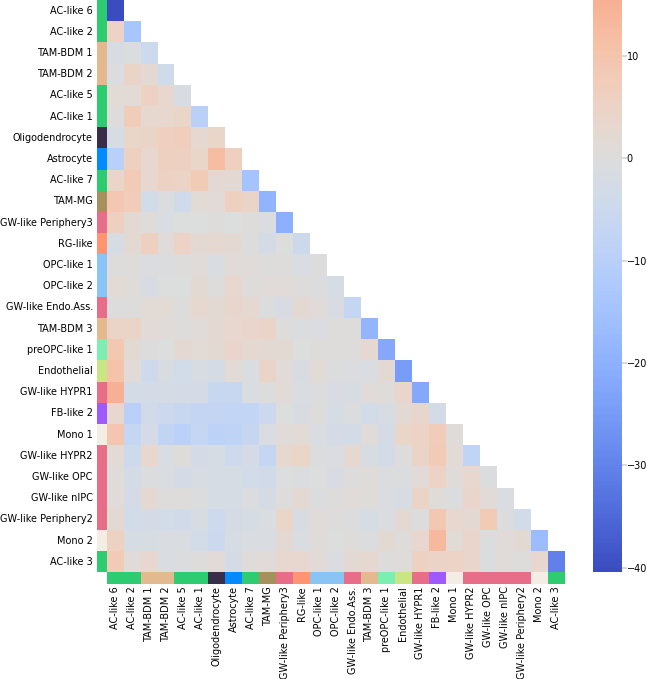

SL040F


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 776.54/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38,

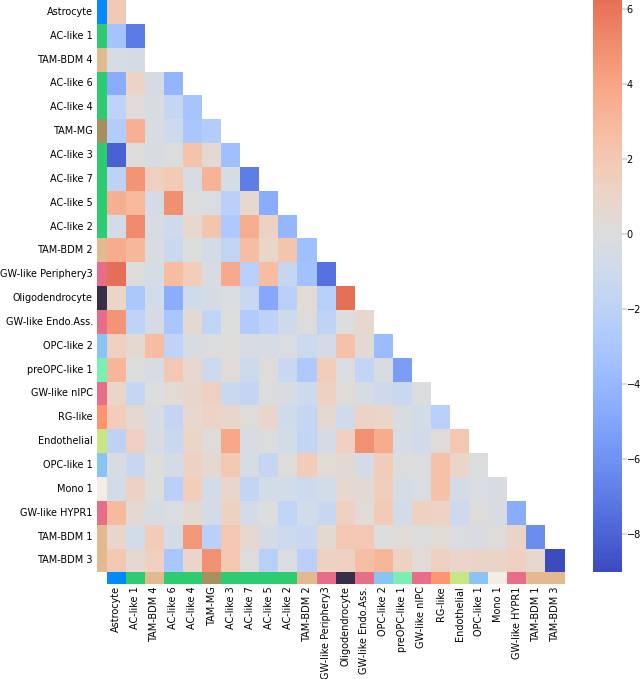

SL040G


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3669.53/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 41, 

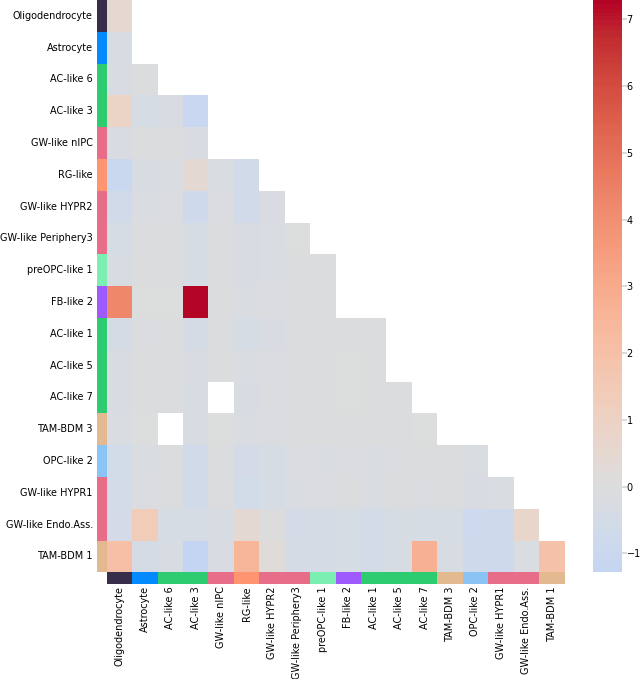

SL046A


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.50/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

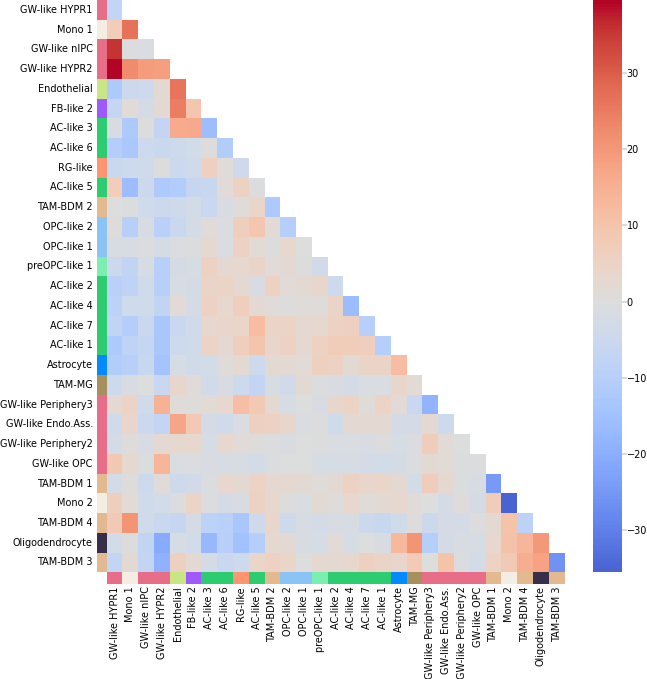

SL046B


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.99/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

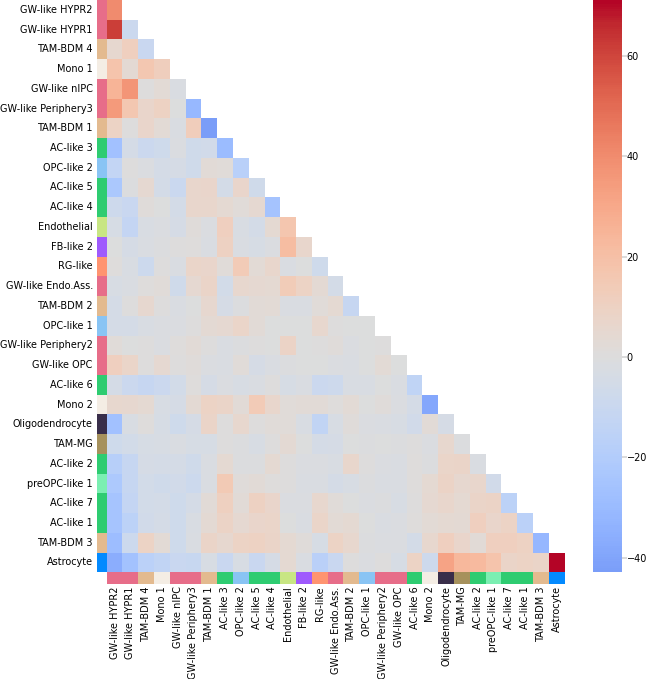

SL046C


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.00/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

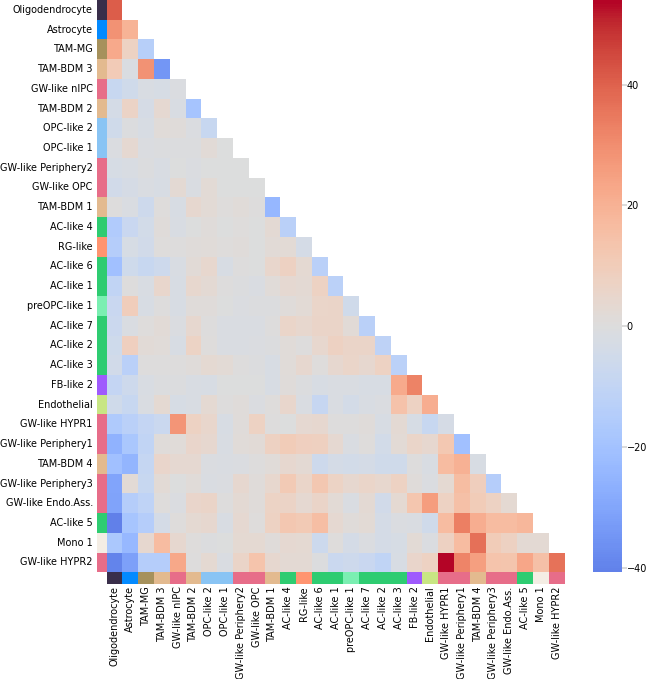

SL047B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.96/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37

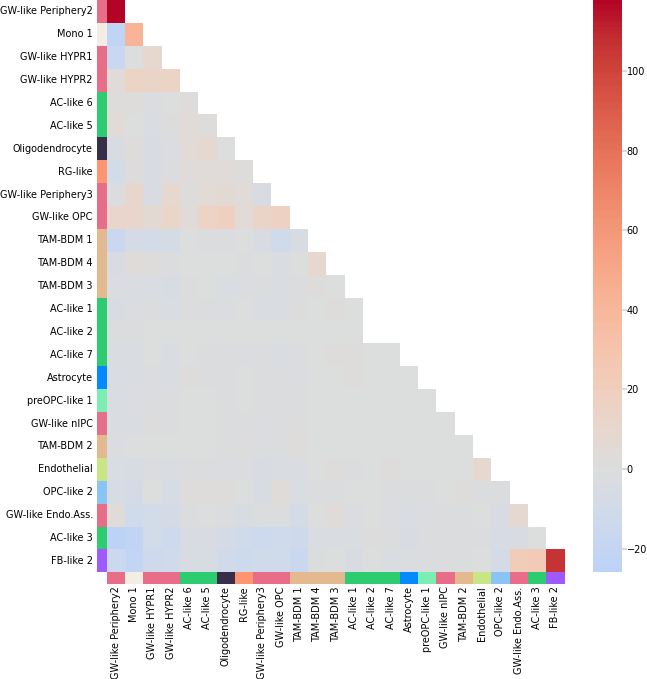

SL053


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.91/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37

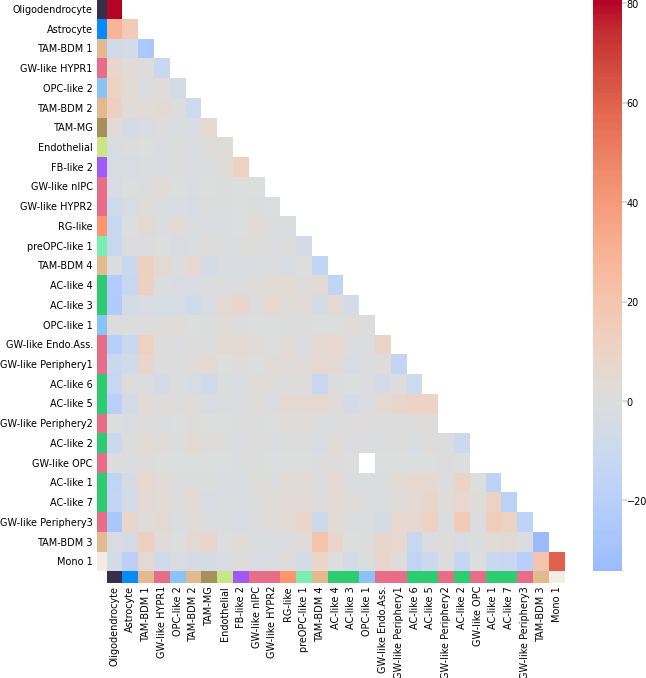

SL057A


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.46/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40,

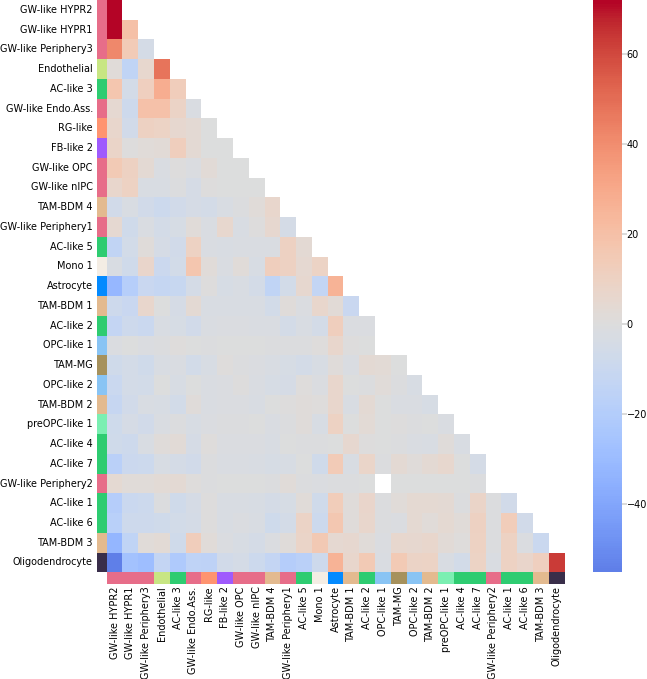

SL057B


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.17/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38,

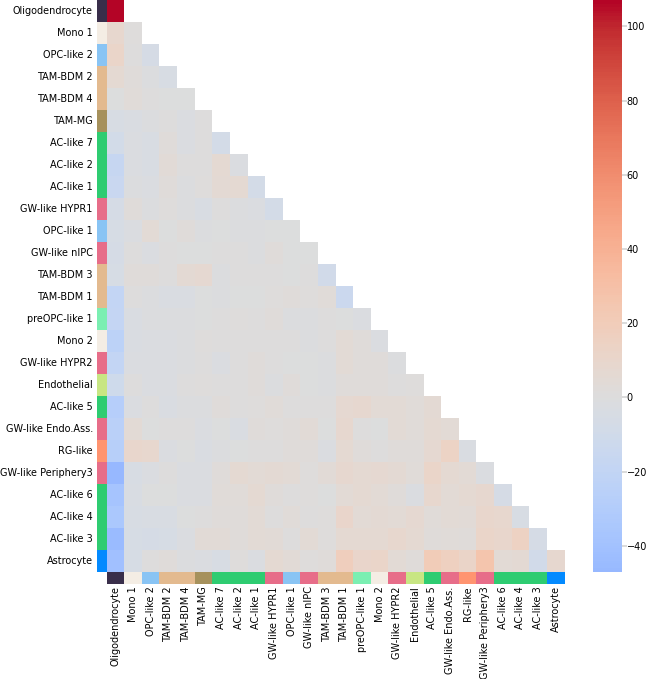

SL061A


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.97/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37

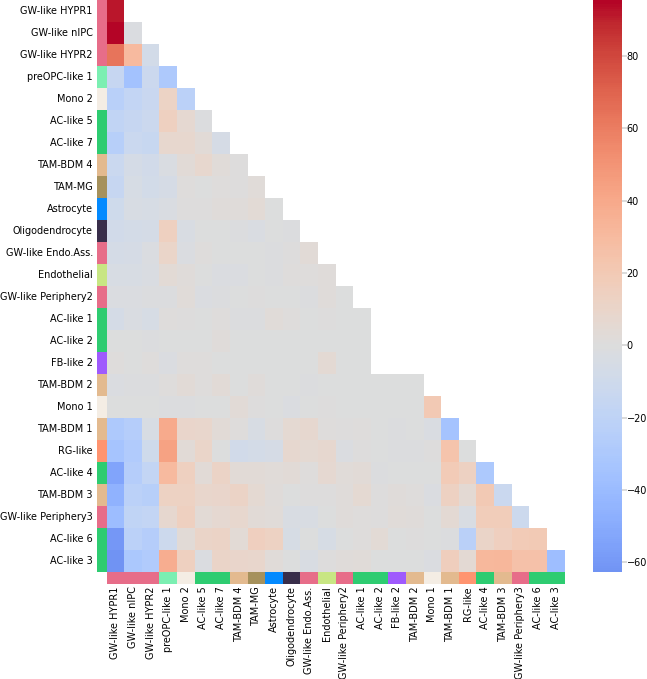

SL061B


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 45.19/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

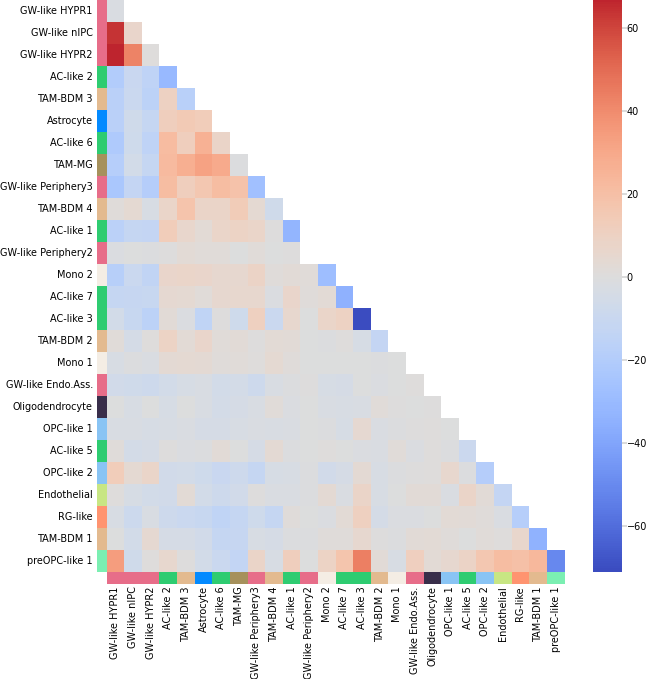

SL061C


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.67/s]
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'M', 'O', 'P', 'R', 'T', 'W', 'Y', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 42, 

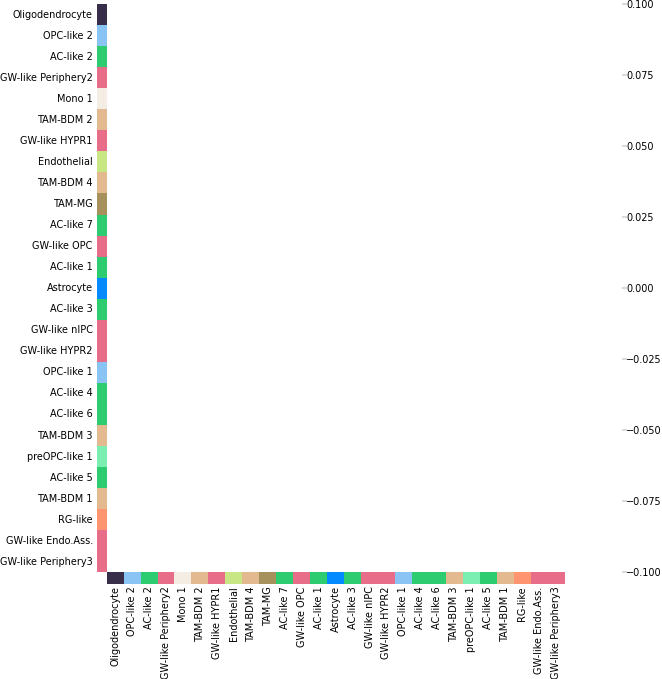

In [39]:
dic_nhood = {} 
samples = []
for s in adata.obs.Sample.cat.categories:
    print(s)
    
    sadata = adata[adata.obs.Sample == s]
    sadata = sadata[sadata.X.sum(axis=1) > 20]
    selected_clusters = list(palette.keys())
    sadata_clusters = sadata[sadata.obs['m-states3'].isin(selected_clusters)]
    if len(sadata_clusters.obs['m-states3'].cat.categories) > 7:

        #try:
        #kdT = KDTree(sadata.obsm['spatial'])
        #d,i = kdT.query(sadata.obsm['spatial'],k=10)
        #d_th = np.percentile(d[:,-1],95)

        sq.gr.spatial_neighbors(sadata_clusters,coord_type="generic", n_neighs=10,delaunay=True,radius=(2.5,50))
        sq.gr.nhood_enrichment(sadata_clusters, cluster_key="m-states3")

        sp.pl.neighborhood_enrichment(
            sadata_clusters, 
            key='m-states3',
            palette=palette,
            save=True,
            figsize=(7,7),
            savepath=f'figures/figures_nn/NN_{s}.pdf'
        )

        df = pd.DataFrame(
        data=sadata_clusters.uns['m-states3_nhood_enrichment']['zscore'], 
        index=sadata_clusters.obs['m-states3'].cat.categories,
        columns=sadata_clusters.obs['m-states3'].cat.categories,

        )

        full_df = pd.DataFrame(np.zeros([len(selected_clusters), len(selected_clusters)]), index=selected_clusters, columns=selected_clusters)
        for s1 in selected_clusters:
            for s2 in selected_clusters:
                try:
                    v = df[s1][s2]
                except:
                    v = 0
                full_df[s1][s2] = v
        dic_nhood[s] = full_df
        samples.append(s)
        #except:
        #    print(f'Could not analyse sample {s}')
            



In [42]:
import pickle
pickle.dump(dic_nhood, open('CellStateNN_20240528.pkl', 'wb'))

In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram
import fastcluster

mutation_df = pd.read_parquet('../MutationLandscape/MutationsPatients.parquet')
import seaborn as sns
palette = sns.color_palette("hls", mutation_df.shape[1])
paletteMutations = {}
for col, gene in zip(palette, mutation_df.columns):
    paletteMutations[gene] = col
'''for m, col in paletteMutations.items():
    print(m , mpl.colors.to_hex(col))'''

In [ ]:
df_samples = pd.DataFrame(
    data=np.array(
        [
            StandardScaler().fit_transform(dic_nhood[k].values).flatten() for k in dic_nhood
            #dic_nhood[k].values.flatten() for k in dic_nhood
        ]
    ).T, 
    columns=list(dic_nhood.keys())
)

#X = StandardScaler().fit_transform(df_samples.values.T)
#df_samples = pd.DataFrame(data=X.T, index=df_samples.index, columns=df_samples.columns)

In [ ]:
metric = 'cosine'
method = 'ward'
D = pdist(df_samples.dropna().T, metric=metric)
#D[np.isnan(D)] = 0
Z = fastcluster.linkage(D, method=method, metric=metric, preserve_input=True)
Z = hc.optimal_leaf_ordering(Z, D, metric=metric)
ordering_samples = hc.leaves_list(Z)

In [ ]:
figsize = (15,5)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True,gridspec_kw={'hspace':0.3})

ax = axs[0]
samples = np.array(samples)
out = dendrogram(Z,labels=df_samples.columns, ax = ax, above_threshold_color='gray', color_threshold=0)
spines = ["top","right","left","bottom"]
for s in spines:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
#ax.set_xticks(np.arange(len(samples)),samples[ordering_samples])
#ax.xaxis.set_tick_params(which='both', labelbottom=True)

#ax.tick_params(axis='x', which='major', pad=10, length=0) 

ax = axs[1]
for i,s in enumerate(samples[ordering_samples]):
    patient = s[:5]
    mut = mutation_df.loc[patient]
    mut = mut[mut != 0].index.tolist()
    for c, m in enumerate(mut):
        ax.scatter(i*10+5, c, s=150, color=paletteMutations[m])
        ax.any
ax.set_yticks([])
#ax.set_xticks([])
spines = ["top","right","left","bottom"]
for s in spines:
    ax.spines[s].set_visible(False)
ax.invert_yaxis()   
#ax.set_xlim(-.1*figsize[0], len(df.columns))
ax.set_ylim(8, -.5)

#plt.setp(axs[0].get_xticklabels(),visible=True, color="r")
axs[0].tick_params(labelbottom=True)
axs[1].tick_params(labelbottom=False)

plt.tight_layout()
#plt.savefig('figures/NNconservation.pdf',dpi=150,transparent=True)